In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Reshape, multiply, MaxPooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from pathlib import Path

In [22]:
# 서버 내 학습데이터 디렉토리 경로
dataset_dir_path = Path("/home/jskwon/Desktop/project-nodal-surrogate/datasets/nodal-code-surrogate-data-registry/ASTRA/const_power_operation/first_cycle_depletion/iSMR/run_250814_cycle_length/processed_data")
artifacts_dir_path = Path("/home/jskwon/Desktop/project-nodal-surrogate/workspace/nodal-code-surrogate-pipeline/notebooks/temp-training-model-cycle_length/temp-artifacts")

# 특정 dir path + "파일명"
mac_xs_voxel_4d_filename = "mac_xs_voxel_4d_250814.npy"
cycle_length_csv_filename = "efpd_interpolation_results.csv"

mac_xs_voxel_4d = np.load(dataset_dir_path/mac_xs_voxel_4d_filename)
df_cycle_length = pd.read_csv(dataset_dir_path/cycle_length_csv_filename, index_col=0) 
cycle_length = df_cycle_length.to_numpy()

In [58]:
cycle_length

array([['1058.409090909091'],
       ['976.2857142857143'],
       ['1036.3636363636363'],
       ...,
       ['Summary Not Found'],
       ['1056.530612244898'],
       ['843.1034482758621']], dtype=object)

In [30]:
cycle_length

array([['1058.409090909091'],
       ['976.2857142857143'],
       ['1036.3636363636363'],
       ...,
       ['Summary Not Found'],
       ['1056.530612244898'],
       ['843.1034482758621']], dtype=object)

In [27]:
mac_xs_voxel_4d.shape

(10000, 24, 5, 5, 10)

In [28]:
invalid_indices_list

[6,
 15,
 36,
 47,
 49,
 53,
 66,
 136,
 171,
 194,
 216,
 223,
 228,
 244,
 258,
 271,
 277,
 287,
 313,
 322,
 329,
 332,
 365,
 376,
 380,
 381,
 411,
 414,
 425,
 448,
 449,
 450,
 458,
 463,
 474,
 484,
 516,
 530,
 531,
 544,
 548,
 565,
 578,
 581,
 601,
 618,
 624,
 626,
 630,
 642,
 643,
 673,
 677,
 707,
 719,
 785,
 789,
 817,
 828,
 836,
 846,
 850,
 863,
 866,
 869,
 872,
 874,
 876,
 885,
 919,
 920,
 926,
 958,
 973,
 1001,
 1049,
 1053,
 1055,
 1056,
 1064,
 1067,
 1075,
 1077,
 1078,
 1084,
 1115,
 1133,
 1153,
 1179,
 1188,
 1191,
 1192,
 1211,
 1242,
 1270,
 1273,
 1275,
 1291,
 1293,
 1306,
 1314,
 1341,
 1348,
 1370,
 1371,
 1382,
 1393,
 1400,
 1401,
 1402,
 1475,
 1495,
 1497,
 1528,
 1535,
 1537,
 1543,
 1545,
 1549,
 1575,
 1577,
 1583,
 1602,
 1614,
 1619,
 1632,
 1678,
 1692,
 1694,
 1705,
 1715,
 1724,
 1732,
 1735,
 1737,
 1744,
 1774,
 1785,
 1795,
 1798,
 1808,
 1813,
 1815,
 1818,
 1845,
 1847,
 1860,
 1866,
 1880,
 1881,
 1886,
 1888,
 1891,
 1893,
 190

In [53]:
# 1. 유효한 데이터(실수)와 잘못된 데이터의 인덱스를 저장할 빈 리스트를 생성합니다.
valid_data_list = []
invalid_indices_list = []

# 2. 원본 배열을 반복하면서 각 항목을 확인합니다.
# enumerate를 사용해 원래 인덱스(idx)와 값(value)을 함께 가져옵니다.
for idx, value in enumerate(cycle_length):
    # value가 ['1058.4...'] 형태의 배열이므로 첫 번째 원소를 추출합니다.
    item = value[0]
    
    try:
        # 3. 문자열을 float(실수)으로 변환 시도
        float_value = float(item)
        # 4. 변환에 성공하면, 유효한 데이터 리스트에 추가합니다.
        valid_data_list.append(float_value)
    except ValueError:
        # 5. 변환에 실패하면 (ValueError 발생), 잘못된 데이터로 간주하고
        #    해당 인덱스를 기록합니다.
        invalid_indices_list.append(idx)

# 6. 리스트들을 최종적인 NumPy 배열로 변환합니다.
clean_cycle_length = np.array(valid_data_list)
invalid_indices = np.array(invalid_indices_list)


# --- 최종 결과 출력 ---
print("--- 처리 결과 ---")
print("실수 데이터만 포함된 새로운 배열:")
print(clean_cycle_length)
print(f"새로운 배열의 형태(shape): {clean_cycle_length.shape}")
print(f"새로운 배열의 타입(dtype): {clean_cycle_length.dtype}\n")

print("제거된 데이터의 원래 인덱스:")
print(invalid_indices)

--- 처리 결과 ---
실수 데이터만 포함된 새로운 배열:
[1058.40909091  976.28571429 1036.36363636 ... 1030.         1056.53061224
  843.10344828]
새로운 배열의 형태(shape): (9191,)
새로운 배열의 타입(dtype): float64

제거된 데이터의 원래 인덱스:
[   6   15   36   47   49   53   66  136  171  194  216  223  228  244
  258  271  277  287  313  322  329  332  365  376  380  381  411  414
  425  448  449  450  458  463  474  484  516  530  531  544  548  565
  578  581  601  618  624  626  630  642  643  673  677  707  719  785
  789  817  828  836  846  850  863  866  869  872  874  876  885  919
  920  926  958  973 1001 1049 1053 1055 1056 1064 1067 1075 1077 1078
 1084 1115 1133 1153 1179 1188 1191 1192 1211 1242 1270 1273 1275 1291
 1293 1306 1314 1341 1348 1370 1371 1382 1393 1400 1401 1402 1475 1495
 1497 1528 1535 1537 1543 1545 1549 1575 1577 1583 1602 1614 1619 1632
 1678 1692 1694 1705 1715 1724 1732 1735 1737 1744 1774 1785 1795 1798
 1808 1813 1815 1818 1845 1847 1860 1866 1880 1881 1886 1888 1891 1893
 1901 1909 1917 1933 1

In [32]:
clean_mac_xs_voxel_4d = np.delete(mac_xs_voxel_4d,    # 원본 배열
                                  invalid_indices,      # 제거할 인덱스 목록
                                  axis=0)  

In [34]:
clean_mac_xs_voxel_4d.shape, clean_cycle_length.shape

((9191, 24, 5, 5, 10), (9191,))

In [35]:
x_mac_xs_4d = clean_mac_xs_voxel_4d
y_cycle_length = clean_cycle_length

x_train, x_test, y_train, y_test = train_test_split(
    x_mac_xs_4d,
    y_cycle_length,
    test_size=0.1,
    random_state=42
    )
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train,
    y_train,
    test_size=0.05,
    random_state=22
    )

In [36]:
from tensorflow.keras.layers import Input, Conv3D, Add, Activation
from tensorflow.keras.models import Model

def residual_block_3d(input_tensor, num_filters, kernel_size):
    # First convolution
    x = layers.Conv3D(num_filters, kernel_size=kernel_size, strides=(1,1,1), padding='same')(input_tensor)
    x = layers.Activation('relu')(x)

    # Second convolution
    x = layers.Conv3D(num_filters, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(x)
    x = layers.Activation('relu')(x)

    # Shortcut path
    shortcut = layers.Conv3D(num_filters, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(input_tensor) # 1x1 합성곱으로 차원 맞춤

    # Add shortcut to output of conv layers
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

In [54]:
from tensorflow.keras.layers import Input, Conv3D, Reshape, add
from tensorflow.keras.models import Model

input_shape = (24, 5, 5, 10)
input_lp = Input(shape=input_shape, name='input_lp')

x = residual_block_3d(input_lp, 99, (15,5,5))
x = residual_block_3d(x, 99, (15,3,3))
x = residual_block_3d(x, 99, (3,3,3))
x = residual_block_3d(x, 1, (3,3,3))
x_flatten = Flatten(name='flatten_features')(x)
x_dense = Dense(128, activation='relu', name='dense_layer_1')(x_flatten)
x_dense = Dense(64, activation='relu', name='dense_layer_2')(x_dense)
output_scalar = Dense(1, name='output_scalar')(x_dense)

model = Model(inputs=input_lp, outputs=output_scalar)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mse')

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_valid = np.array(x_valid, dtype=np.float32)
y_valid = np.array(y_valid, dtype=np.float32)

history = model.fit(x_train, y_train, epochs=150, validation_data=(x_valid, y_valid))
model.save("experiment-250911-cycle_length-v0.h5")

Epoch 1/150
246/246 [==============================] - 10s 30ms/step - loss: 135871.1250 - val_loss: 34444.5078
Epoch 2/150
246/246 [==============================] - 7s 30ms/step - loss: 38305.8438 - val_loss: 36315.3125
Epoch 3/150
246/246 [==============================] - 8s 31ms/step - loss: 37661.5586 - val_loss: 34355.7617
Epoch 4/150
246/246 [==============================] - 8s 31ms/step - loss: 36463.1094 - val_loss: 32638.8398
Epoch 5/150
246/246 [==============================] - 8s 31ms/step - loss: 32716.7480 - val_loss: 29959.6348
Epoch 6/150
246/246 [==============================] - 8s 31ms/step - loss: 26992.9629 - val_loss: 22664.7109
Epoch 7/150
246/246 [==============================] - 8s 31ms/step - loss: 21966.7363 - val_loss: 16467.0762
Epoch 8/150
246/246 [==============================] - 8s 31ms/step - loss: 21339.2715 - val_loss: 17052.2715
Epoch 9/150
246/246 [==============================] - 8s 31ms/step - loss: 21209.7520 - val_loss: 15745.0547
Epoch 10

In [56]:
y_pred

array([ 844.8014 ,  944.2251 ,  925.01306, 1049.8528 ,  913.34656,
       1006.9709 , 1092.7903 ,  972.8213 , 1071.3883 ,  893.15753,
       1108.6802 ,  937.797  ,  967.86255,  852.9775 ,  914.73584,
        683.8624 , 1014.8319 ,  757.5165 ,  726.1218 , 1023.0561 ,
       1083.9042 ,  961.2345 ,  943.3924 ,  818.31604,  893.7112 ,
        930.61206,  918.80756,  846.9798 ,  981.1977 , 1041.2793 ,
        831.5934 ,  876.2947 ,  956.73206,  835.2074 , 1018.76843,
        920.5083 ,  777.7185 ,  750.682  ,  997.6457 , 1005.01855,
       1066.9119 ,  999.9728 ,  982.9256 ,  874.7101 , 1175.9312 ,
        933.9586 , 1021.87805,  898.9848 , 1079.4768 ,  578.68646,
        966.17737,  913.2495 ,  846.5608 , 1070.9224 ,  945.46387,
        965.0183 , 1035.6693 , 1010.9636 , 1068.4307 ,  947.7676 ,
        979.5185 ,  889.6685 ,  804.4486 , 1071.5459 , 1014.91064,
        911.66016, 1090.1138 ,  862.3573 ,  734.3572 ,  696.7483 ,
        991.03107, 1072.1543 ,  870.74786,  986.09033, 1205.53

In [57]:
y_test_flat

array([ 946.25      , 1050.        ,  923.33333333, 1113.26086957,
        891.14285714, 1067.75      , 1214.54545455,  983.54166667,
       1127.44186047,  889.76190476, 1176.36363636,  873.5       ,
        903.25581395,  987.74193548,  934.21052632,  626.15384615,
       1108.60465116,  784.09090909,  895.3125    , 1144.88888889,
       1177.69230769,  989.44444444,  976.36363636,  986.85714286,
        851.70731707, 1024.70588235, 1053.75      ,  808.94736842,
       1044.72222222, 1003.33333333,  952.85714286, 1029.35483871,
       1027.64705882,  909.73684211, 1131.31578947,  938.28571429,
        800.83333333,  739.09090909, 1129.47368421, 1013.69565217,
       1221.4893617 , 1073.95348837, 1094.56521739,  797.87878788,
       1280.        ,  875.76923077, 1099.02439024,  924.28571429,
       1158.5       ,    7.14285714, 1077.6744186 ,  937.35294118,
        969.35483871, 1129.55555556, 1085.65217391,  992.09302326,
       1038.29268293, 1070.78431373, 1170.        , 1001.35135

In [55]:
import numpy as np

# 1. 모델을 사용해 x_test에 대한 예측 수행
y_pred = model.predict(x_test).flatten()
y_test_flat = y_test.flatten()

# 2. 0으로 나누는 것을 방지하기 위해 실제값이 0이 아닌 데이터만 필터링
non_zero_mask = y_test_flat != 0
y_test_filtered = y_test_flat[non_zero_mask]
y_pred_filtered = y_pred[non_zero_mask]

# 3. 상대평균오차(MAPE) 계산
absolute_percentage_errors = np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)
mean_absolute_percentage_error = np.mean(absolute_percentage_errors) * 100

print(f"테스트 데이터셋에 대한 상대평균오차(MAPE): {mean_absolute_percentage_error:.2f} %")

29/29 [==============================] - 1s 16ms/step
테스트 데이터셋에 대한 상대평균오차(MAPE): 200.67 %


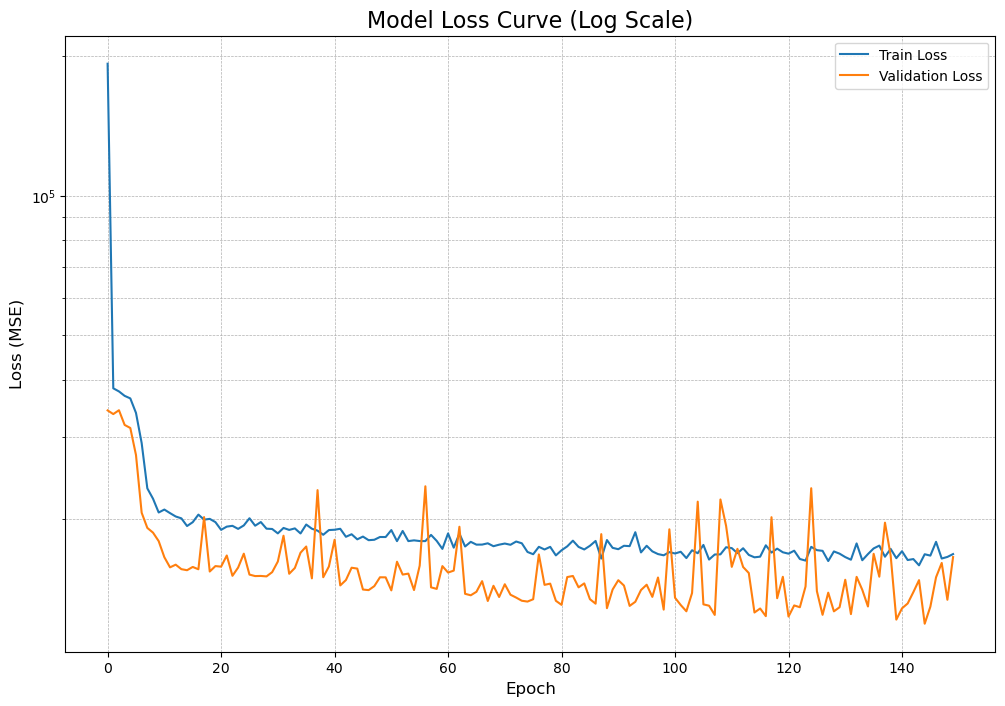

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Y축 눈금 제어를 위해 import

# history 객체는 model.fit()의 결과물이라고 가정합니다.

# --- 1. Figure 및 Axes 객체 생성 ---
fig, ax = plt.subplots(figsize=(12, 8))

# --- 2. Loss 및 Validation Loss 그래프 그리기 ---
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')

# --- 3. 그래프 스타일 및 정보 추가 ---
ax.set_title('Model Loss Curve (Log Scale)', fontsize=16)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_xlabel('Epoch', fontsize=12)
ax.legend(loc='upper right')

# --- 4. Y축을 로그 스케일로 변경하고 눈금을 촘촘하게 설정 (핵심) ---
ax.set_yscale('log')

# **핵심 코드: LogLocator를 사용하여 y축의 주 눈금(major ticks) 개수를 늘립니다.**
# numticks 값을 늘리면 Matplotlib가 데이터 범위 내에서 더 많은 10의 거듭제곱 눈금을 찾으려고 시도합니다.
# 데이터의 최소/최대값 범위에 따라 적절한 값을 찾아보세요. (예: 10, 15, 20)
locator = mticker.LogLocator(numticks=15)
ax.yaxis.set_major_locator(locator)

# 그리드는 가독성을 위해 주/보조 눈금 모두에 표시합니다.
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# --- 5. 그래프 출력 ---
plt.show()

데이터 검토

In [59]:
clean_cycle_length

array([1058.40909091,  976.28571429, 1036.36363636, ..., 1030.        ,
       1056.53061224,  843.10344828])

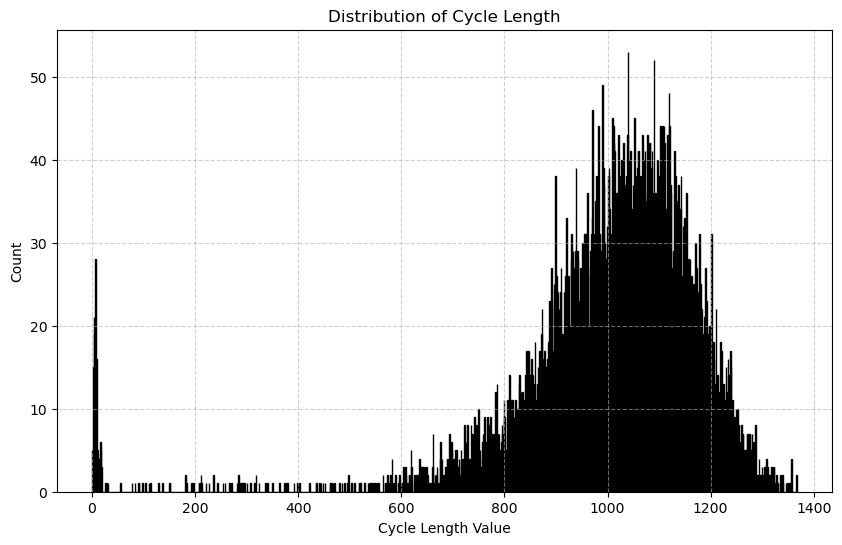

In [64]:

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 히스토그램 생성
# bins: 막대의 개수를 의미하며, 숫자를 조절하여 그래프의 상세도를 변경할 수 있습니다.
# edgecolor: 막대 사이의 경계선 색상입니다.
plt.hist(clean_cycle_length, bins=1000, color='deepskyblue', edgecolor='black')

# 그래프 제목 및 축 레이블 추가
plt.title('Distribution of Cycle Length')
plt.xlabel('Cycle Length Value')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)

# 그래프 표시
plt.show()

In [65]:
# 각 범주별 개수를 저장할 딕셔너리(key-value) 초기화
category_counts = {
    "0 ~ 100": 0,
    "100 ~ 500": 0,
    "500 ~ 1000": 0,
    "1000 이상": 0
}

# 모든 데이터를 하나씩 확인하며 해당하는 범주의 개수를 1씩 증가
for value in clean_cycle_length:
    if 0 <= value < 100:
        category_counts["0 ~ 100"] += 1
    elif 100 <= value < 500:
        category_counts["100 ~ 500"] += 1
    elif 500 <= value < 1000:
        category_counts["500 ~ 1000"] += 1
    elif value >= 1000:
        category_counts["1000 이상"] += 1

# 최종 결과 출력
print("--- 범주별 데이터 개수 (Key-Value) ---")
for category, count in category_counts.items():
    print(f"{category}: {count}")

--- 범주별 데이터 개수 (Key-Value) ---
0 ~ 100: 155
100 ~ 500: 68
500 ~ 1000: 3544
1000 이상: 5424
